Imports

In [ ]:
from parameters_U235_pump_transient import *
from jitcdde import t
from msrDynamics import Node, System
import pandas as pd
import os
from scipy.interpolate import interp1d
import sympy as sp

This notebook simulates pump transients for the MSRE at zero power (10W). A dynamical system representing the MSRE is built using the [msrDynamics](https://github.com/LukeLabrie/msrDynamics) tool. The system is run at steady-state until $t = 2500$, where the fuel and coolant pumps are spun down at the rate defined by the ORNL data. After allowing the system to settle to a new equilibrium, at $t = 7500$, the pumps are spun up again. The model includes a reactivity response, `rho_control`, which models the response of the MSRE control rod to maintain constant power. It is modeled as a pure integrator of $\frac{dn}{dt}$ from the point-kinetics equations with a coefficient of -1.0, i.e. it tries to exactly cancel reactivity changes introduced by flow changes, with the caveat that changes are limited to $\pm$29 pcm/s, which was the maximum rate achievable by the MSRE control rods. 

In [8]:
# plotting style 
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "monospace"

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

# function to update the style of each axis
def update_axis_style(ax, title = None, x_label='', y_label='', x_ticks=True,fsl = 12, fsb = 12, fst = 14):
    if title:
        ax.set_title(title,fontsize=fst)
    ax.set_xlabel(x_label,fontsize=fsb)
    ax.set_ylabel(y_label,fontsize=fsl)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.tick_params(axis='x', which='both', bottom=x_ticks, top=False, labelbottom=x_ticks)
    ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)

In [ ]:
# set up system 

MSRE = System()

# define flow events
df_spindown = pd.read_csv(os.getcwd() + '/data/spindown.csv', names = ['time', 'pct'], header = None)
df_spinup = pd.read_csv(os.getcwd() + '/data/spinup.csv', names = ['time', 'pct'], header = None)
spindown_fit = interp1d(df_spindown['time'], df_spindown['pct'])
spinup_fit = interp1d(df_spinup['time'], df_spinup['pct'])
t_spindown = 2500
t_spinup = 7500

def flow_fac(t):
    if (t <= t_spindown):
        return 1.0
    elif (t < (t_spindown + 20.0)):
        return max(spindown_fit(t-t_spindown)/100.0, 0.02)
    elif (t <= t_spinup):
        return 0.02
    elif (t < t_spinup + 8.20):
        return max(spinup_fit(t-t_spinup)/100.0, 0.02)
    else:
        return 1.0

flow_pct = MSRE.add_input(flow_fac, T, max_anchors = 5000, input_tol = 32)

In [ ]:
# define nodes

# radiator
T_out_rc = Node(m=mn_rp, scp=mcp_rpn/mn_rp, W=W_rp, y0=T0_rp, name='T_out_rc')
T_out_air = Node(m=mn_rs, scp=mcp_rsn/mn_rs, W=W_rs, y0=T0_rs, name='T_out_air')

# heat exchanger
T_hf1 = Node(m=mn_p, scp=mcp_pn/mn_p, W=W_p*flow_pct, y0=T0_p1, name='T_hf1')
T_hf2 = Node(m=mn_p, scp=mcp_pn/mn_p, W=W_p*flow_pct, y0=T0_p2, name='T_hf2')
T_hf3 = Node(m=mn_p, scp=mcp_pn/mn_p, W=W_p*flow_pct, y0=T0_p3, name='T_hf3')
T_hf4 = Node(m=mn_p, scp=mcp_pn/mn_p, W=W_p*flow_pct, y0=T0_p4, name='T_hf4')
T_ht1 = Node(m=m_tn, scp=scp_t, y0=T0_t1, name='T_ht1')
T_ht2 = Node(m=m_tn, scp=scp_t, y0=T0_t2, name='T_ht2')
T_hc1 = Node(m=mn_s, scp=mcp_sn/mn_s, W=W_s*flow_pct, y0=T0_s1, name='T_hc1')
T_hc2 = Node(m=mn_s, scp=mcp_sn/mn_s, W=W_s*flow_pct, y0=T0_s2, name='T_hc2')
T_hc3 = Node(m=mn_s, scp=mcp_sn/mn_s, W=W_s*flow_pct, y0=T0_s3, name='T_hc3')
T_hc4 = Node(m=mn_s, scp=mcp_sn/mn_s, W=W_s*flow_pct, y0=T0_s4, name='T_hc4')

# core 
n = Node(y0=n_frac0, name='n')
C1 = Node(y0=C0[0], name='C1')
C2 = Node(y0=C0[1], name='C2')
C3 = Node(y0=C0[2], name='C3')
C4 = Node(y0=C0[3], name='C4')
C5 = Node(y0=C0[4], name='C5')
C6 = Node(y0=C0[5], name='C6')
rho = Node(y0=rho_0, name='rho')

rho_control = Node(y0=0.0, name='rho_control')

T_cg = Node(m=mcp_g1/scp_g, scp=scp_g, y0=T0_g1, name='T_cg')
T_cf1 = Node(m=mn_f, scp=scp_f, W=W_f*flow_pct, y0=T0_f1, name='T_cf1')
T_cf2 = Node(m=mn_f, scp=scp_f, W=W_f*flow_pct, y0=T0_f1, name='T_cf2')

MSRE.add_nodes([T_out_rc,T_out_air,T_hf1,T_hf2,T_hf3,T_hf4,T_ht1,T_ht2,T_hc1,
               T_hc2,T_hc3,T_hc4,n,C1,C2,C3,C4,C5,C6,T_cg,T_cf1,T_cf2,rho, rho_control])

# dynamics

# radiator
T_out_rc.set_dTdt_advective(source = T_hc4.y(t-tau_hx_r/flow_pct))
T_out_rc.set_dTdt_convective(source = [T_out_air.y()], hA = [hA_rpn*flow_pct])

T_out_air.set_dTdt_advective(source = Trs_in)
T_out_air.set_dTdt_convective(source = [T_out_rc.y()], hA = [hA_rsn])

# heat exchanger
T_hf1.set_dTdt_advective(source = T_cf2.y(t-tau_c_hx/flow_pct))
T_hf1.set_dTdt_convective(source = [T_ht1.y()], hA = [hA_pn*flow_pct])

T_hf2.set_dTdt_advective(source = T_hf1.y())
T_hf2.dTdt_convective = T_hf1.dTdt_convective

T_hf3.set_dTdt_advective(source = T_hf2.y())
T_hf3.set_dTdt_convective(source = [T_ht2.y()], hA = [hA_pn*flow_pct])

T_hf4.set_dTdt_advective(source = T_hf3.y())
T_hf4.dTdt_convective = T_hf3.dTdt_convective

T_ht1.set_dTdt_convective(source = [T_hf1.y(),T_hf1.y(),T_hc3.y(),T_hc3.y()], hA = [hA_pn*flow_pct,hA_pn*flow_pct,hA_sn*flow_pct,hA_sn*flow_pct])
T_ht2.set_dTdt_convective(source = [T_hf3.y(),T_hf3.y(),T_hc1.y(),T_hc1.y()], hA = [hA_pn*flow_pct,hA_pn*flow_pct,hA_sn*flow_pct,hA_sn*flow_pct])

T_hc1.set_dTdt_advective(source = T_out_rc.y(t-tau_r_hx/flow_pct))
T_hc1.set_dTdt_convective(source = [T_ht2.y()], hA = [hA_sn*flow_pct])

T_hc2.set_dTdt_advective(source = T_hc1.y())
T_hc2.dTdt_convective = T_hc1.dTdt_convective

T_hc3.set_dTdt_advective(source = T_hc2.y())
T_hc3.set_dTdt_convective(source = [T_ht1.y()], hA = [hA_sn*flow_pct])

T_hc4.set_dTdt_advective(source = T_hc3.y())
T_hc4.dTdt_convective = T_hc3.dTdt_convective

# core
n.set_dndt(r = rho.y() + rho_control.y(), beta_eff = beta_t, Lambda = Lam, lam = lam, C = [C1.y(),C2.y(),C3.y(),C4.y(),C5.y(),C6.y()])
C1.set_dcdt(n.y(), beta = beta[0],Lambda = Lam, lam = lam[0], t_c = tau_c/flow_pct, t_l = tau_l/flow_pct, flow = True)
C2.set_dcdt(n.y(), beta = beta[1],Lambda = Lam, lam = lam[1], t_c = tau_c/flow_pct, t_l = tau_l/flow_pct, flow = True)
C3.set_dcdt(n.y(), beta = beta[2],Lambda = Lam, lam = lam[2], t_c = tau_c/flow_pct, t_l = tau_l/flow_pct, flow = True)
C4.set_dcdt(n.y(), beta = beta[3],Lambda = Lam, lam = lam[3], t_c = tau_c/flow_pct, t_l = tau_l/flow_pct, flow = True)
C5.set_dcdt(n.y(), beta = beta[4],Lambda = Lam, lam = lam[4], t_c = tau_c/flow_pct, t_l = tau_l/flow_pct, flow = True)
C6.set_dcdt(n.y(), beta = beta[5],Lambda = Lam, lam = lam[5], t_c = tau_c/flow_pct, t_l = tau_l/flow_pct, flow = True)

# control rod response
rho_control.dydt = -sp.Min(29.0e-5, sp.Max(-29.0e-5, n.dydt))


T_cg.set_dTdt_convective(source = [T_cf1.y()], hA = [hA_fg*flow_pct])
T_cg.set_dTdt_internal(source = [n.y()], k = [k_g*P])

T_cf1.set_dTdt_advective(source = T_hf4.y(t-tau_hx_c/flow_pct))
T_cf1.set_dTdt_convective(source = [T_cg.y()], hA = [k_1*hA_fg*flow_pct])
T_cf1.set_dTdt_internal(source = [n.y()], k = [k_f1*P])

T_cf2.set_dTdt_advective(source = T_cf1.y())
T_cf2.dTdt_convective = T_cf1.dTdt_convective
T_cf2.set_dTdt_internal(source = [n.y()], k = [k_f2*P])

rho.set_drdt(sources = [T_cf1.dydt, T_cg.dydt], coeffs = [a_f,a_g])

In [ ]:
# solve 
sol_jit = MSRE.solve(T, max_delay = 30.0, abs_tol = 1e-12, rel_tol = 1e-10, min_step = 1e-13, populate_nodes = True)


finalizing integrator...
integrating...


Integration progress:   0%|          | 0/1000000 [00:00<?, ?it/s]

Generating, compiling, and loading C code.


Integration progress: 100%|██████████| 1000000/1000000 [05:19<00:00, 3128.32it/s]


populating nodes objects solution vectors...


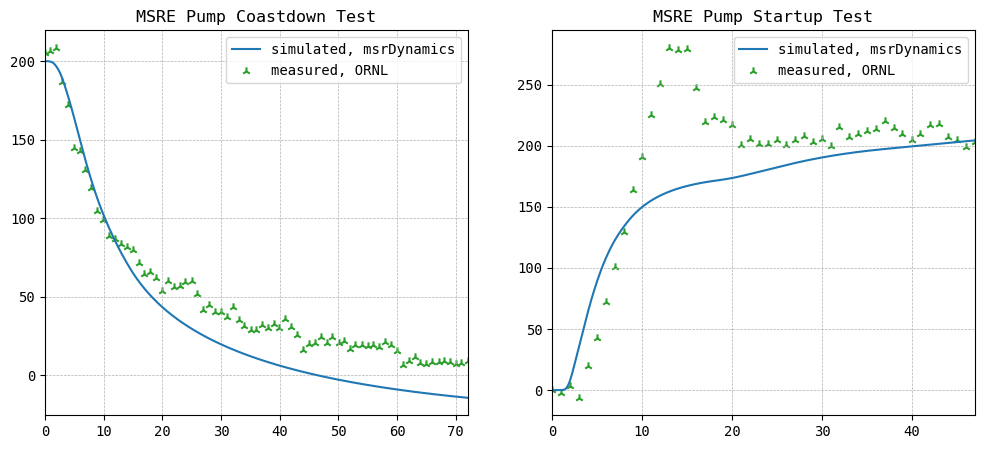

In [ ]:
df_ornl_spindown = pd.read_csv(os.getcwd() + '/data/ornl_spindown.csv', header = None, names = ['time', 'pcm'])
df_ornl_spinup = pd.read_csv(os.getcwd() + '/data/ornl_spinup.csv', header = None, names = ['time', 'pcm'])

fig, axs = plt.subplots(1,2, figsize = (12,5))

T_compare_spindown = T[(T >= 2500.0) & (T <= 2572.0)] -2500
rho_compare_spindown = 200+(rho_control.y_out[(T >= 2500.0) & (T <= 2572.0)])*1e5

T_compare_spinup = T[(T >= 7500.0) & (T <= 7547.0)] -7500
rho_compare_spinup = 200+(rho_control.y_out[(T >= 7500.0) & (T <= 7547.0)])*1e5

update_axis_style(axs[0], title = 'MSRE Pump Coastdown Test')
axs[0].plot(T_compare_spindown, rho_compare_spindown, label = 'simulated, msrDynamics')
axs[0].scatter(df_ornl_spindown['time'], df_ornl_spindown['pcm'], marker="2",color=colors[2],label="measured, ORNL")
axs[0].set_xlim([0,72])
axs[0].legend()

update_axis_style(axs[1], title = 'MSRE Pump Startup Test')
axs[1].plot(T_compare_spinup, rho_compare_spinup-rho_compare_spinup[0], label = 'simulated, msrDynamics')
axs[1].scatter(df_ornl_spinup['time'], df_ornl_spinup['pcm'], marker="2",color=colors[2],label="measured, ORNL")
axs[1].set_xlim([0,47])
axs[1].legend()